In [152]:
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter(x, y, bins=50, xlim=None, ylim=None, filename=None):
    fig = plt.figure(figsize=(10, 10))
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
import matplotlib.animation as animation

In [59]:
rays_y = np.loadtxt("rays_y_0.00.dat")

<IPython.core.display.Javascript object>


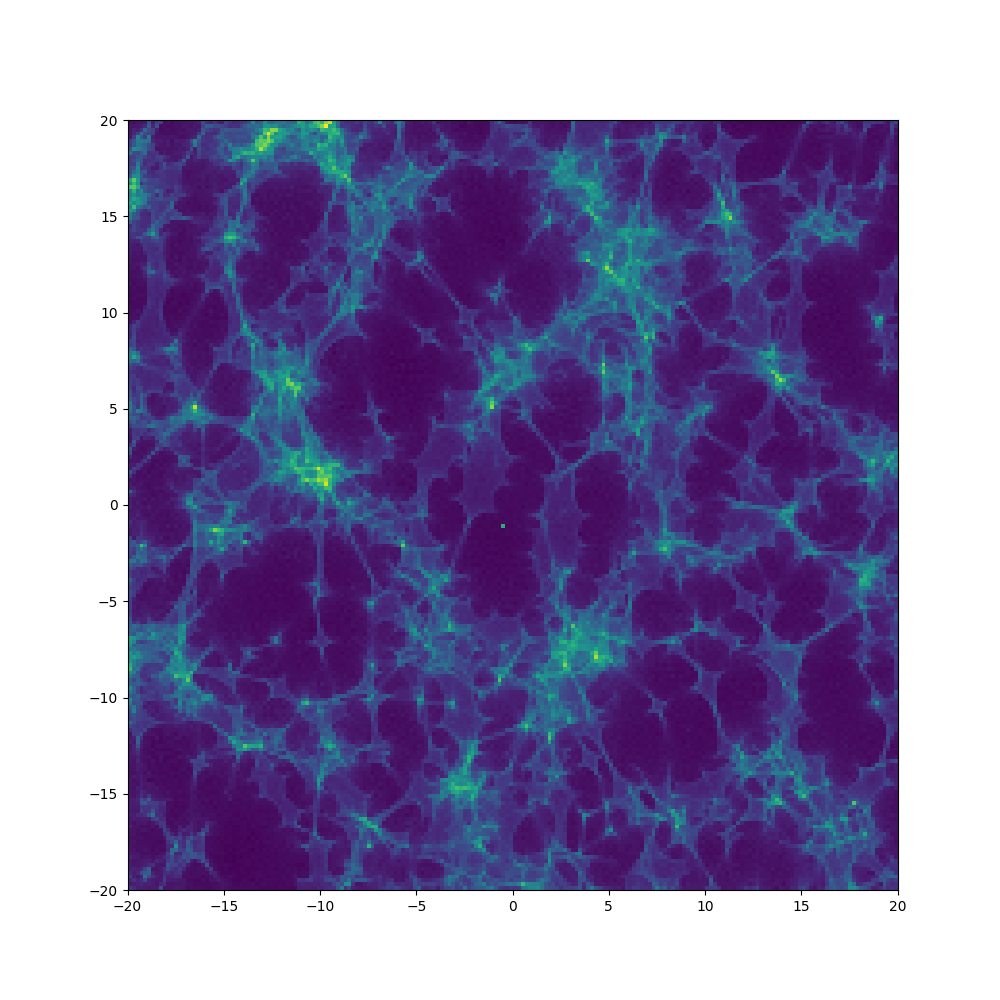

In [153]:
m = np.logical_and(np.abs(rays_y[:,0]) <= 20, np.abs(rays_y[:,1]) <= 20)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[200, 200])

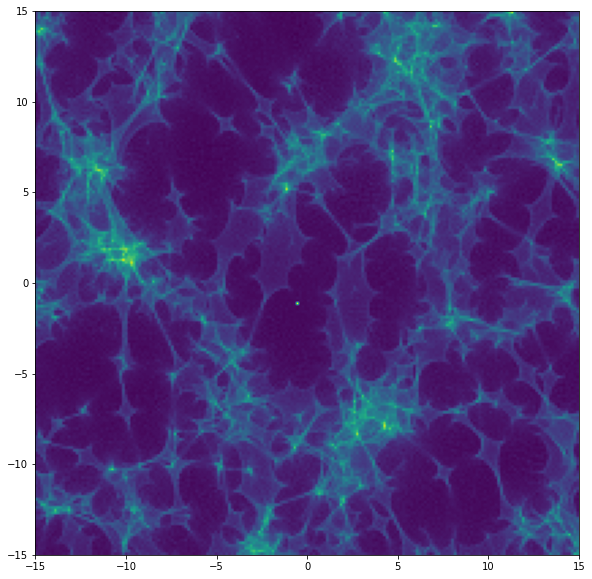

In [94]:
m = np.logical_and(np.abs(rays_y[:,0]) <= 15, np.abs(rays_y[:,1]) <= 15)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[200, 200])

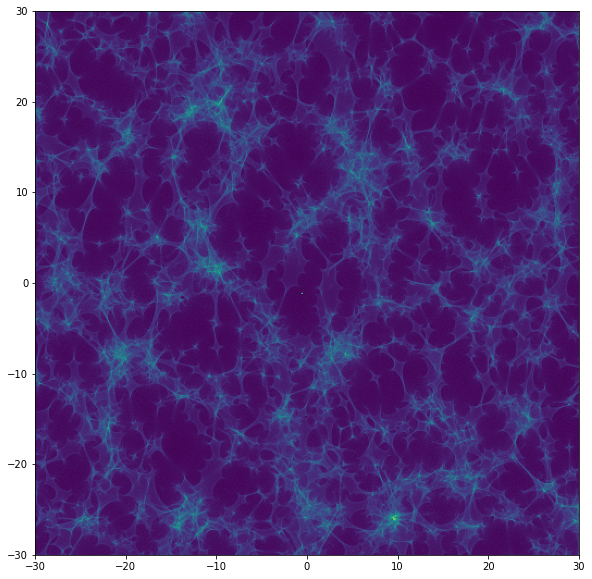

In [62]:
m = np.logical_and(np.abs(rays_y[:,0]) <= 30, np.abs(rays_y[:,1]) <= 30)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[500, 500])

<IPython.core.display.Javascript object>


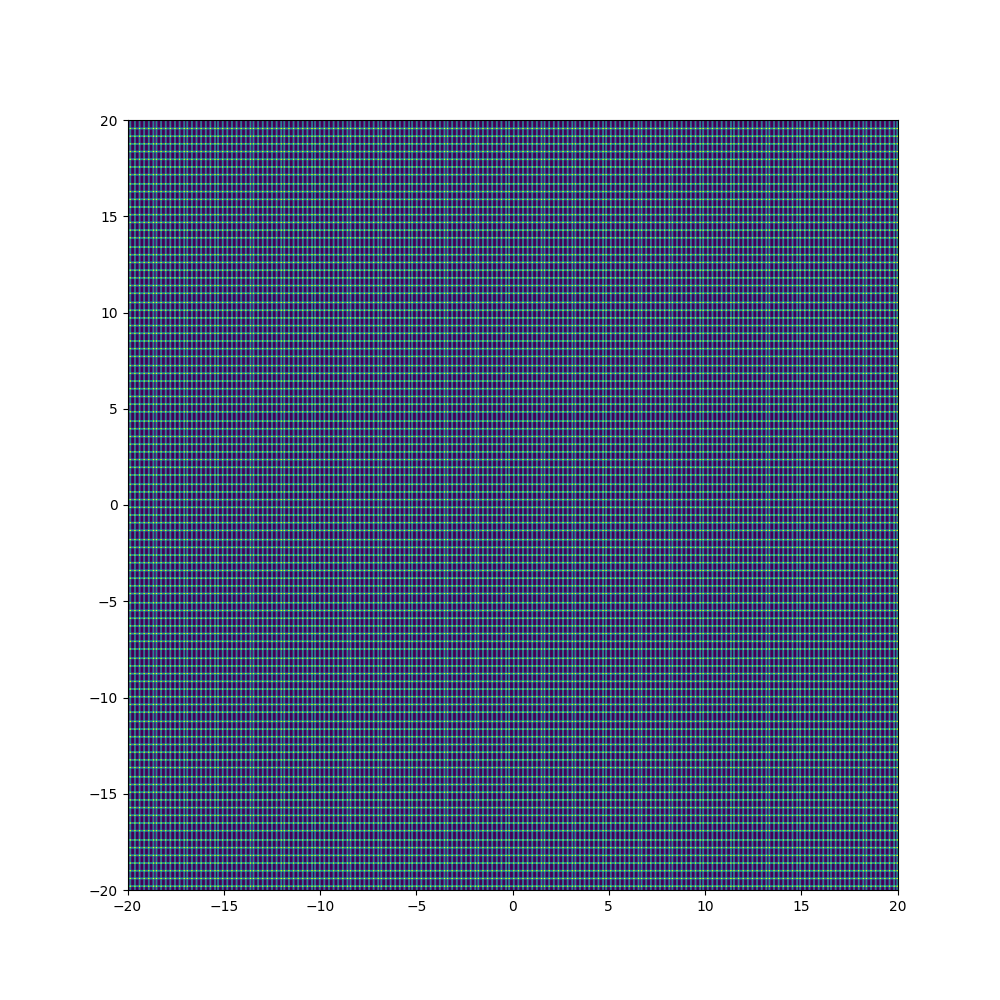

8245475.0

In [182]:
filename = "image_0.00.dat"
image = np.loadtxt(filename).reshape([500,500])
extent = None
with open(filename, 'r') as f:
    header1 = f.readline().strip()
    header2 = f.readline().strip()
    
    _x = re.split('\(|\,|\)', header1)
    _y = re.split('\(|\,|\)', header2)
    extent = [float(_x[1]),float(_x[2]),float(_y[1]),float(_y[2])]

fig = plt.figure(figsize=(10, 10))
im = np.zeros_like(image)
im[image > 0] = np.log(image[image > 0])
plt.imshow(im, extent=extent, origin='lower')
plt.show()

np.sum(image)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

<IPython.core.display.Javascript object>


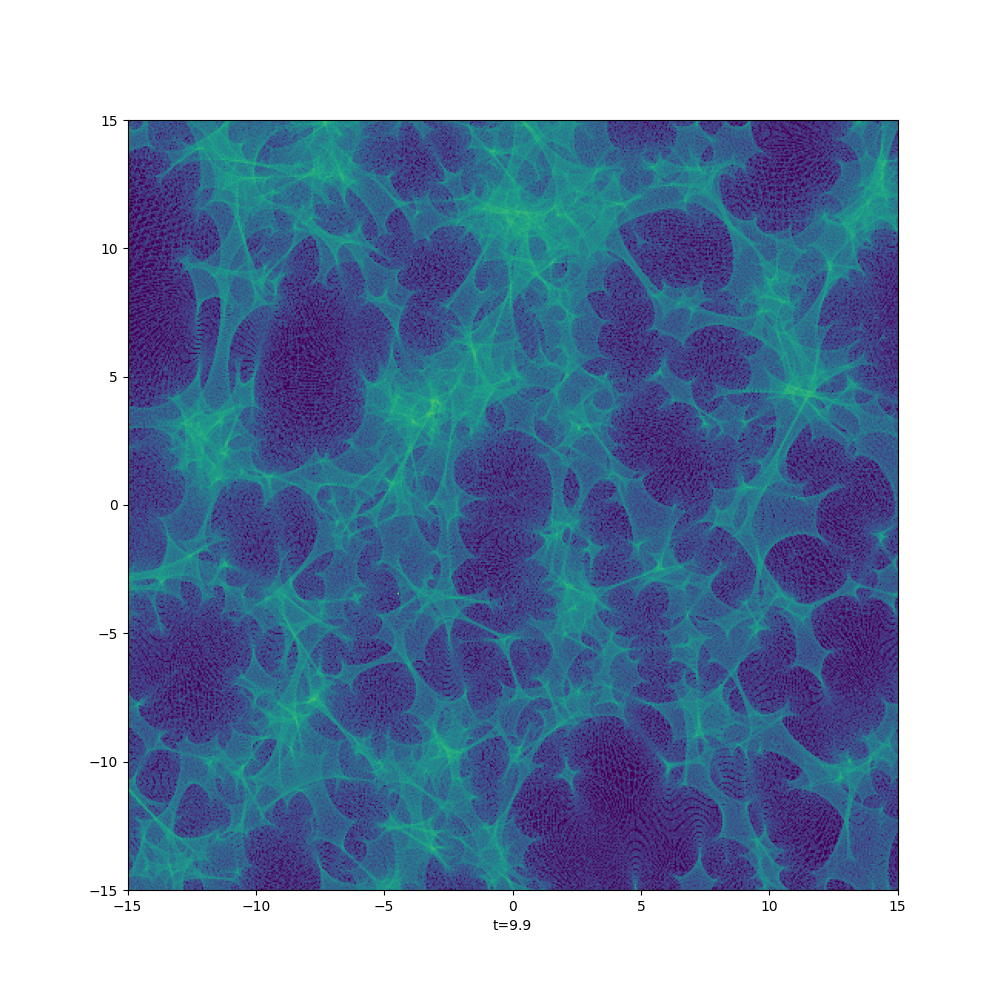

image_0.00.dat 17288956.0
image_0.10.dat 17288463.0
image_0.20.dat 17289709.0
image_0.30.dat 17290326.0
image_0.40.dat 17292349.0
image_0.50.dat 1555861.0
image_0.60.dat 1557298.0
image_0.70.dat 1558994.0
image_0.80.dat 1560742.0
image_0.90.dat 1562760.0
image_1.00.dat 1564563.0
image_1.10.dat 1566782.0
image_1.20.dat 1569191.0
image_1.30.dat 1571601.0
image_1.40.dat 1574147.0
image_1.50.dat 1576548.0
image_1.60.dat 1578978.0
image_1.70.dat 1581396.0
image_1.80.dat 1584080.0
image_1.90.dat 1586454.0
image_2.00.dat 1589272.0
image_2.10.dat 1591954.0
image_2.20.dat 1593995.0
image_2.30.dat 1596064.0
image_2.40.dat 1597959.0
image_2.50.dat 1599683.0
image_2.60.dat 1601151.0
image_2.70.dat 1602562.0
image_2.80.dat 1603496.0
image_2.90.dat 1604621.0
image_3.00.dat 1605330.0
image_3.10.dat 1605892.0
image_3.20.dat 1606544.0
image_3.30.dat 1607250.0
image_3.40.dat 1608730.0
image_3.50.dat 1609995.0
image_3.60.dat 1611290.0
image_3.70.dat 1612735.0
image_3.80.dat 1613621.0
image_3.90.dat 16149

In [176]:
fig, ax = plt.subplots(figsize=(10,10))

ims = []

for i in np.arange(0, 10, 0.1):
    filename = "image_%.2f.dat" % i
    image = np.loadtxt(filename).reshape([500,500])
    print(filename, np.sum(image))
    extent = None
    with open(filename, 'r') as f:
        header1 = f.readline().strip()
        header2 = f.readline().strip()

        _x = re.split('\(|\,|\)', header1)
        _y = re.split('\(|\,|\)', header2)
        extent = [float(_x[1]),float(_x[2]),float(_y[1]),float(_y[2])]

    img = np.zeros_like(image)
    img[image > 0] = np.log(image[image > 0])
    im = ax.imshow(img, extent=extent, origin='lower')
    ax.set_xlabel("t=%s" % i)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False, repeat_delay=1000)

# To save the animation, use e.g.

ani.save("moving_stars.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()